# MusicLab Copenhagen Audience Characteristics


- Describe locations of participants in hall and relationship constellations

- Describe audience participants by survey responses 


In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
# %aimport frf

In [3]:
%reload_ext autoreload

In [4]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [5]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [6]:
# datafiles including information not green for open publication
internal_Part = general_loc + 'Participants_internal/'

In [7]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [8]:
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
# concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [9]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # A in person hall participants, B remote participants 
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
print(len(aligned_Part_Codes))
alignedParts.iloc[:5,:]

115


,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [10]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


In [11]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
bad_gaps = []
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
#     print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        AX3_correction_factor = 5
        trial_dic[part] = pd.Series(index=dt_ct,data=b*AX3_correction_factor)
    else:
#         aud_df.loc[:,part] = b
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

146.5183560848236
146.60428023338318


In [12]:
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)
aud_df.index = dt_ct

In [11]:
# or retreive from previous extraction
aud_df = pd.read_csv('./data/essential/Audience_10Hz_sampled.csv',index_col=0)
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()

In [12]:
ori_aud_df.iloc[:5,:]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN,NaN,NaN,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN,NaN,NaN,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN,NaN,NaN,NaN


# Participants by location
Note: this is the only not published information about the audience used in the Audience motion paper.

In [13]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
alignedParts = partDets.loc[~partDets['Aligned_DevID'].isna(),:]


In [15]:
D = pd.DataFrame(index=aud_df.index,columns=aud_df.columns)
for c in aud_df.columns:
    D.loc[aud_df[c].isna(),c]=1
#exclude the interval from coverage percentate
coverage = pd.concat([D.loc[:concert_times.loc[23,'Datetime'],:],D.loc[concert_times.loc[24,'Datetime']:,:]],axis=0) 

partDets.set_index('Participant_Code',inplace=True)
partDets['Z'] = coverage.sum()/len(coverage)
partDets.reset_index(inplace=True)

TypeError: '<' not supported between instances of 'float' and 'Timestamp'

In [16]:
Near_Rels = pd.read_csv('./data/Audience/Near_Participants_Hall.csv')

KeyError: 'Z'

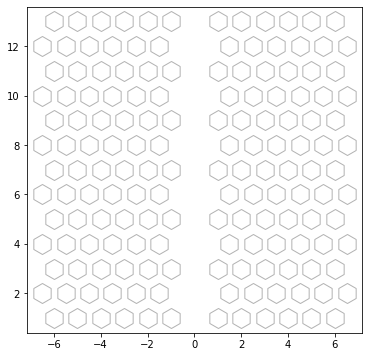

In [17]:
seating = pd.DataFrame()
offs = 0
seating['Y'] = np.concatenate((np.arange(-6,0,1)-offs,np.arange(1,7,1)+offs))
seating['X'] = 1
seating['Z'] = 0
for rows in range(2,14):
    offs=np.mod((1+rows)/2,1)
    this_row = pd.DataFrame(columns=['Y','X','Z'])
    this_row['Y'] = np.concatenate((np.arange(-6,0,1)-offs,np.arange(1,7,1)+offs))
    this_row['X'] = rows
    this_row['Z'] = 0
    seating=pd.concat([seating,this_row],axis=0).reset_index(drop=True)

plt.figure(figsize=[6,6])
plt.scatter(x=seating['Y'],y=seating['X'],c='w',edgecolors='grey', s=400, marker="h", alpha=0.6,)
sc=plt.scatter(x=partDets['Y'],y=partDets['X'], c=1-partDets['Z'], cmap='Purples',vmin=0,vmax=1, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,14.5])
plt.colorbar(sc,label='Ratio motion captured')

plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title('In Hall participants: location, relations')

# now add the relationships Friends
Friends = Near_Rels[Near_Rels['Relationship'].str.contains('Friend')]
Family = Near_Rels[Near_Rels['Relationship'].str.contains('Family')]

ship = Friends.iloc[0,:]
P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'b',linewidth = 1)
ship = Family.iloc[0,:]
P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'r',linewidth = 1,linestyle=':')    
    
for i,ship in Friends.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'b',linewidth = 1)


for i,ship in Family.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'r',linewidth = 1,linestyle='--')

plt.legend(['Seats','Participants','Friends','Family'],ncols=2,loc='upper center')
plt.ylabel('Seating Rows')
# show the graph
plt.savefig('./plots/Inhall_Audience_Locations.png',dpi = 196)
plt.show()

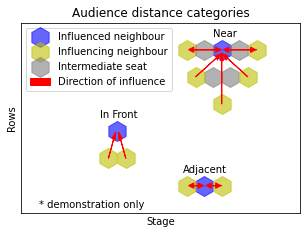

In [18]:
plt.figure(figsize=[5,3.5])

# in front influence
sc=plt.scatter(x=[3.5],y=[7],c ='b', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[1.5,5.5],y=[7,7],c ='y', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[2.5,4.5],y=[7,7],c ='grey', s=400, marker="h", alpha=0.6)

plt.arrow(3.5,7,-1.6,0,color='r',head_width=0.2)

plt.legend(['Influenced neighbour','Influencing neighbour','Intermediate seat','Direction of influence'],
          loc='upper left')
sc=plt.scatter(x=[3.0,4.0],y=[6,6],c ='grey', s=400, marker="h", alpha=0.6)

plt.arrow(1.75,7,1.4,0,color='r',head_width=0.2)

plt.arrow(5.5,7,-1.6,0,color='r',head_width=0.2)
plt.arrow(3.75,7,1.4,0,color='r',head_width=0.2)

sc=plt.scatter(x=[2.0,5.0],y=[6,6],c ='y', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[3.5],y=[5],c ='y', s=400, marker="h", alpha=0.6)
plt.arrow(2.0,6,1.2,0.7,color='r',head_width=0.2)
plt.arrow(5.0,6,-1.2,0.7,color='r',head_width=0.2)
plt.arrow(3.5,5,0,1.6,color='r',head_width=0.2)

plt.annotate('Near',[3,7.5],)

# adjancents influence
sc=plt.scatter(x=[2.5],y=[2],c ='b', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[1.5,3.5],y=[2,2],c ='y', s=400, marker="h", alpha=0.6)
plt.arrow(2.5,2,-0.6,0,color='r',head_width=0.2)
plt.arrow(1.75,2,0.4,0,color='r',head_width=0.2)
plt.arrow(3.5,2,-0.6,0,color='r',head_width=0.2)
plt.arrow(2.75,2,0.4,0,color='r',head_width=0.2)
plt.annotate('Adjacent',[1.25,2.5],)

# in front influence
sc=plt.scatter(x=[-2.5],y=[4],c ='b', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[-2.0,-3.0],y=[3,3],c ='y', s=400, marker="h", alpha=0.6)
plt.arrow(-2.0,3,-0.3,0.7,color='r',head_width=0.2)
plt.arrow(-3.0,3,0.3,0.7,color='r',head_width=0.2)
plt.annotate('In Front',[-3.5,4.5],)

plt.annotate('* demonstration only',[-7,1.2],)
plt.xlim([-8,8])
plt.ylim([1,8])
# plt.colorbar(sc,label='% motion captured')

plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title('Audience distance categories')
plt.ylabel('Rows')
plt.savefig('./supplemental_plots/Spatial_relationships.png',dpi = 196)
plt.show()

# Participant Stats

Extract and articulate relevant statistics from the demographics portion of the participant survey. 

In [35]:
# pull audience questionnair responses
Quest_text = pd.read_csv(public_Part + 'Surveys_Codebook.csv', delimiter=",", encoding='latin-1')
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
Quest_df.set_index(Quest_df['ParticipantCode'],inplace = True,drop = True)
# only want the responses of people with aligned motion measurements
Quest_df = Quest_df.loc[aligned_Part_Codes,:].copy()#.reset_index(drop = True)
HQ_df = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('A'),:].copy()
RQ_df = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('B'),:].copy()
Quest_df.iloc[:5,:]

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
ParticipantCode,,,,,,,,,,,,,,,,,,,,,
ADQ001,ADQ001,60.0,Woman,Music-loving nonmusician,No_Relation,7.0,4.0,3.0,3.0,2.0,...,NaN,3.714286,3.666667,144,3.6,3.5,4.3,3.833333,4.166667,3.833333
ADQ002,ADQ002,84.0,Man,Music-loving nonmusician,No_Relation,7.0,1.0,5.0,1.0,5.0,...,NaN,1.000000,1.000000,108,3.7,3.6,3.0,4.833333,4.833333,4.166667
ADQ003,ADQ003,46.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,1.0,4.0,1.0,...,NaN,4.428571,4.333333,127,1.4,1.3,2.9,1.000000,2.833333,1.833333
ADQ004,ADQ004,57.0,Man,Music-loving nonmusician,No_Relation,7.0,2.0,3.0,4.0,2.0,...,NaN,3.714286,3.500000,154,1.9,1.1,3.1,3.500000,4.333333,3.666667
ADQ005,ADQ005,47.0,Man,Serious amateur musician,Relative_Friend,7.0,2.0,3.0,3.0,4.0,...,NaN,2.428571,2.500000,117,1.2,2.8,3.6,3.000000,2.666667,3.500000


In [36]:
[len(HQ_df),len(RQ_df)]

[85, 30]

In [59]:
q = 1
Quest_text.loc[q,:]

ID                                         age
English_Q                    What is your age?
Danish_Q                    Hvad er din alder?
Response_Type                          integer
Data_Type                              integer
Response_Options_English    free text response
Response_Options_Danish                    NaN
Survey_Timing                      Pre-concert
Survey_Timing_Code                         1.0
Repeated_Question_Code                     NaN
Note                                       NaN
Reference                                  NaN
Name: 1, dtype: object

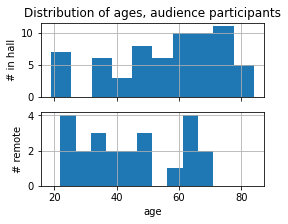

In [60]:
fig,(axes) = plt.subplots(2,1,figsize=(4,3),sharex=True)
HQ_df[Quest_text.loc[q,'ID']].hist(ax=axes[0])
axes[0].set_xlabel(Quest_text.loc[q,'ID'])
axes[0].set_ylabel('# in hall')
axes[0].set(title='Distribution of ages, audience participants',xlabel='')
RQ_df[Quest_text.loc[q,'ID']].hist(ax=axes[1])
axes[1].set_xlabel(Quest_text.loc[q,'ID'])
axes[1].set_ylabel('# remote')
plt.savefig('./supplemental_plots/Participants_age_dist.png',dpi = 196)
plt.show()

In [61]:
q = 4
Quest_text.loc[q,:]

ID                                                          personal_relation
English_Q                   What is your personal relationship to the Dani...
Danish_Q                    Hvad er din personlige relation til medlemmern...
Response_Type                                                 multiple choice
Data_Type                                                              string
Response_Options_English    "I am a relative/friend, I dont have any part...
Response_Options_Danish     "Jeg er en ven/familie, Jeg har ikke nogen bes...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                                                                      NaN
Reference                                                                 NaN
Name: 4, dtype: object

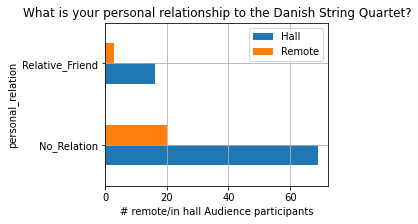

,Hall,Remote
personal_relation,,
No_Relation,0.811765,0.869565
Relative_Friend,0.188235,0.130435


In [62]:
R_df = pd.DataFrame()
R_df['Hall'] = HQ_df[Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = RQ_df[Quest_text.loc[q,'ID']].value_counts()

R_df.plot.barh(figsize=(4, 3))
# plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.grid()
plt.xlabel('# remote/in hall Audience participants')
plt.savefig('./supplemental_plots/Participants_RelationshipDSQ_dist.png',bbox_inches = 'tight',dpi = 196)
plt.show()
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df

In [63]:
q = 3
Quest_text.loc[q,:]

ID                                                            musician_status
English_Q                                     Which title best describes you?
Danish_Q                            Hvilken beskrivelse passer bedst til dig?
Response_Type                                                 multiple choice
Data_Type                                                              string
Response_Options_English    "Tone-deaf, Nonmusician, Music-loving nonmusic...
Response_Options_Danish     "Tonedøv, Ikke-musiker, Musikelskende ikke-mus...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                        "A single item measure for identifying musicia...
Reference                                              Zhang & Schubert, 2019
Name: 3, dtype: object

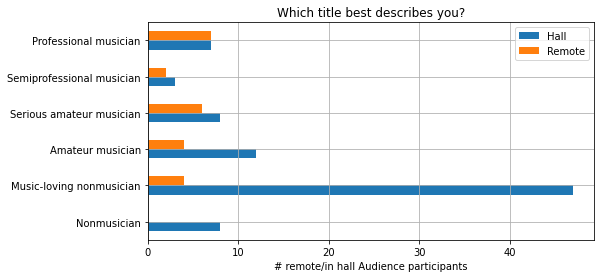

,Hall,Remote
Professional musician,0.082353,0.304348
Semiprofessional musician,0.117647,0.391304
Serious amateur musician,0.211765,0.652174
Amateur musician,0.352941,0.826087
Music-loving nonmusician,0.905882,1.000000
Nonmusician,1.000000,NaN


In [64]:
R_df = pd.DataFrame(index = ['Nonmusician','Music-loving nonmusician', 'Amateur musician', 
       'Serious amateur musician', 'Semiprofessional musician', 'Professional musician'])
R_df['Hall'] = HQ_df[Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = RQ_df[Quest_text.loc[q,'ID']].value_counts()

R_df.plot.barh(figsize=(8,4))
# plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.xlabel('# remote/in hall Audience participants')
plt.grid()
plt.savefig('./supplemental_plots/Participants_Musicianship_dist.png',bbox_inches = 'tight',dpi = 196)

plt.show()
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

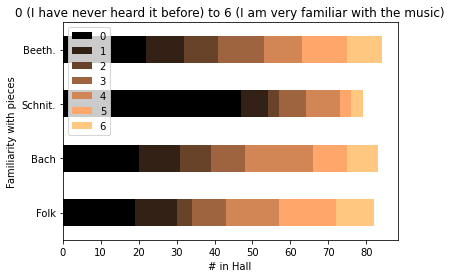

In [33]:
# Quest_df.iloc[:,[39,79,100,131]].hist(alpha = 0.55) 
R_df = pd.DataFrame(index = range(0,7),columns = ['Folk','Bach','Schnit.','Beeth.'])
R_df['Beeth.'] = HQ_df.iloc[:,39].value_counts()
R_df['Schnit.'] =  HQ_df.iloc[:,79].value_counts()
R_df['Bach'] =  HQ_df.iloc[:,100].value_counts()
R_df['Folk'] =  HQ_df.iloc[:,131].value_counts()
R_df.transpose().plot.barh(stacked=True,colormap='copper')
plt.ylabel('Familiarity with pieces')
plt.xlabel('# in Hall')
plt.title(Quest_text.loc[39,'Response_Options_English'])
plt.savefig('./supplemental_plots/Participants_Familiarity_Music_dist.png',bbox_inches = 'tight',dpi = 196)

plt.show()

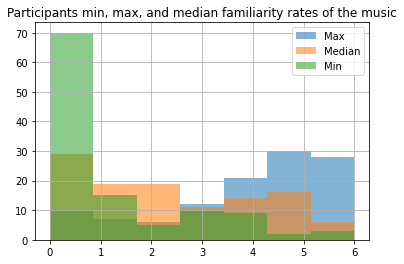

In [28]:
Quest_df.iloc[:,[39,79,100,131]].max(axis=1).hist(bins=7,alpha = 0.55,label='Max') 
Quest_df.iloc[:,[39,79,100,131]].median(axis=1).hist(bins=7,alpha = 0.55,label='Median')
Quest_df.iloc[:,[39,79,100,131]].min(axis=1).hist(bins=7,alpha = 0.55,label='Min')
plt.title('Participants min, max, and median familiarity rates of the music')
plt.legend() 
plt.savefig('./supplemental_plots/Participants_Familiarity_Music_MinMax_dist.png',dpi = 196)
plt.show()